In [2]:
# @title Inputs (General)
import numpy as np

# Line Positions
vLineBias_mm = 700e-3; #[mm]
hLineBias_mm = -400e-3; #[mm]
base_mm = 100e-3; #mm
vLines_mm = np.array([-1, 0, 1]) * base_mm + vLineBias_mm
hLines_mm = np.array([-2, 0, 1, 2]) * base_mm + hLineBias_mm
#vLines_mm = np.array([-4, 0, 1, 3]) * base_mm + vLineBias_mm
#hLines_mm = np.array([-3, -2, 1, 3]) * base_mm + hLineBias_mm

In [3]:
# @title Inputs (Cutting)

cut_position = "1" #@param [1,2,3,4]
cut_position = int(cut_position)
mirror = "False" #@param ["True","False"]
mirror = mirror == "True"

In [4]:
# @title Inputs (Point Positions)

# On the fluorescence image, what coordinates are on the line [mm]
# Lines from left to right
l0_pt = np.array([ [0.143, 0], [0.143, 1]])
l1_pt = np.array([ [0.272, 0], [0.272, 1]])
l2_pt = np.array([ [0.412, 0], [0.412, 1]])
l3_pt = np.array([ [1.359, 0], [1.359, 1]])
l4_pt = np.array([ [1.492, 0], [1.492, 1]])
l5_pt = np.array([ [1.625, 0], [1.625, 1]])
l6_pt = np.array([ [1.894, 0], [1.894, 1]])

v0.60, v0.70, v0.80, h-0.20, h-0.30, h-0.40, h-0.60, 

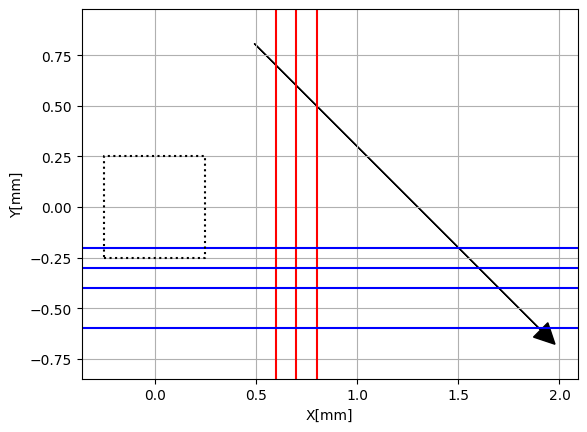

In [5]:
# @title Pattern
import matplotlib.pyplot as plt

def draw_pattern(
    vLines_mm, # Position of vertical lines
    hLines_mm, # Position of horizontal lines
    oct_scan_size_mm=0.5, # Size of the OCT scan around the center
    reverse_plot=False, # Set to true if the flourecence image is reversed
    ):
  # Plot Pattern
  for vline in vLines_mm:
      plt.axvline(x=vline, color='r', linestyle='-')
  for hline in hLines_mm:
      plt.axhline(y=hline, color='b', linestyle='-')
  # Plot OCT Scan
  square_x = [-oct_scan_size_mm/2, oct_scan_size_mm/2, oct_scan_size_mm/2, -oct_scan_size_mm/2, -oct_scan_size_mm/2]
  square_y = [-oct_scan_size_mm/2, -oct_scan_size_mm/2, oct_scan_size_mm/2, oct_scan_size_mm/2, -oct_scan_size_mm/2]
  plt.plot(square_x, square_y, color='k', linestyle=':')

  # Figure out the scale of the lines
  vLines_center_mm = np.mean(vLines_mm)
  hLines_center_mm = np.mean(hLines_mm)
  scale_mm = np.round(np.max([
      np.max(vLines_mm) - np.min(vLines_mm),
      np.max(hLines_mm) - np.min(hLines_mm),
      oct_scan_size_mm])*4)

  plt.xlim(vLines_center_mm-scale_mm, vLines_center_mm+scale_mm)
  plt.ylim(hLines_center_mm-scale_mm, hLines_center_mm+scale_mm)

  plt.xlabel('X[mm]')
  plt.ylabel('Y[mm]')
  plt.grid(True)
  plt.axis('equal')
  if reverse_plot:
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
  #plt.show()

def _draw_pattern():
  draw_pattern(vLines_mm,hLines_mm, reverse_plot=mirror)
_draw_pattern()


# Slice Line
if cut_position == 1:
  x_scale =  1
  y_scale =  1
  cut_flip = False
  line_id_group = ['v','v','v', 'h','h','h','h']
  line_id_pos = np.concatenate((vLines_mm, np.flipud(hLines_mm)), axis=0)
elif cut_position == 2:
  x_scale = -1
  y_scale =  1
  cut_flip = True
  line_id_group = ['h','h','h','h','v','v','v']
  line_id_pos = np.concatenate((hLines_mm, vLines_mm), axis=0)
elif cut_position == 3:
  x_scale = -1
  y_scale = -1
  cut_flip = True
  line_id_group = ['h','h','h','h','v','v','v']
  line_id_pos = np.concatenate((np.flipud(hLines_mm), vLines_mm), axis=0)
elif cut_position == 4:
  x_scale =  1
  y_scale = -1
  cut_flip = False
  line_id_group = ['v','v','v','h','h','h','h']
  line_id_pos = np.concatenate((vLines_mm, hLines_mm), axis=0)

x = x_scale*np.array([-1,1]) + vLineBias_mm + x_scale*0.5
y = y_scale*np.array([1,-1]) + hLineBias_mm + y_scale*0.5

# Center x,y makes sure it's length is 2mm
dir = np.array([x[1]-x[0],y[1]-y[0]])
dir = dir/np.linalg.norm(dir)*2
x_mid = np.mean(x)
y_mid = np.mean(y)
x = np.array([x_mid-dir[0]/2,x_mid+dir[0]/2])
y = np.array([y_mid-dir[1]/2,y_mid+dir[1]/2])

if cut_flip:
  x = np.flipud(x)
  y = np.flipud(y)
if mirror:
  line_id_group = np.flipud(line_id_group)
  line_id_pos = np.flipud(line_id_pos)
  x = np.flipud(x)
  y = np.flipud(y)
plt.arrow(x[0], y[0], x[1] - x[0], y[1] - y[0], color='k', head_width=0.1, head_length=0.1)

# Print the ids
for group, pos in zip(line_id_group, line_id_pos):
    print(f"{group}{pos:.2f}", end=", ")

plt.show()

In [6]:
print(line_id_group)

['v', 'v', 'v', 'h', 'h', 'h', 'h']


In [7]:
# @title Compute Alignment
# Reference: https://github.com/WinetraubLab/HashtagAlignment/blob/master/99%20Algorithms/fdlnEstimateUVHSinglePlane.m

# Create the least square matrix
def gen_row (
    ln_pts, # Points on the specific line
    ln_id_group, # Can be 'h' or 'v'
    ln_id_pos,   # The physical position in mm
    ):
  y_row = []
  A_row = []
  for ln_pt in ln_pts:
    y.append(ln_id_pos) # least square y is the line position [mm]
    if ln_id_group == 'v':
      A_row.append([ln_pt[0], 0, ln_pt[1], 0, 1, 0])
    else:
      A_row.append([0, ln_pt[0], 0, ln_pt[1], 0, 1])

  A_row = np.array(A_row)
  y_row = np.array(y_row)

  return (A_row,y_row)

A = []
y = []
A_row, y_row = gen_row(l0_pt,line_id_group[0],line_id_pos[0])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l1_pt,line_id_group[1],line_id_pos[1])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l2_pt,line_id_group[2],line_id_pos[2])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l3_pt,line_id_group[3],line_id_pos[3])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l4_pt,line_id_group[4],line_id_pos[4])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l5_pt,line_id_group[5],line_id_pos[5])
A.append(A_row)
y.append(y_row)
A_row, y_row = gen_row(l6_pt,line_id_group[6],line_id_pos[6])
A.append(A_row)
y.append(y_row)

A = np.vstack(A)
y = np.hstack(y)

# Solve the least square problem
x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)

# Output vectors
u_x = x[0]
u_y = x[1]
v_x = x[2]
v_y = x[3]
h_x = x[4]
h_y = x[5]

# Estimate z by solving equation A and equation B
def eq_A(u_x,u_y,v_x,v_y):
  return u_x*v_x+u_y*v_y
def eq_B(u_x,u_y,v_x,v_y):
  return u_x**2-v_x**2+u_y**2-v_y**2
def eq_vz(u_x,u_y,v_x,v_y):
  A = eq_A(u_x,u_y,v_x,v_y)
  B = eq_B(u_x,u_y,v_x,v_y)
  return 1/np.sqrt(2)*np.sqrt(B+np.sqrt(B**2-4*A**2))

v_z = eq_vz(u_x,u_y,v_x,v_y)
u_z = -eq_A(u_x,u_y,v_x,v_y)/v_z

u = np.array([u_x,u_y,u_z])
v = np.array([v_x,v_y,v_z])
h = np.array([h_x,h_y,0])
print(u)
print(v)
print(h)
print(np.linalg.norm(u))
print(np.linalg.norm(v))

[ 7.43080238e-01 -7.47536419e-01 -7.78002093e-17]
[2.22044605e-16 1.11022302e-16 1.05402986e+00]
[0.49515755 0.81545175 0.        ]
1.0540298560828878
1.0540298560828878


In [5]:
import numpy as np
print(max(10,np.Inf))

inf
